# Multiclass Adam (and SGD) on a general problem class

#### Notes
 
 - I super recommend using a GPU to run this, otherwise it's slow.
 - Code currently can't handle a non-diagonal data covariance for Adam. The "gradient noise term" isn't calculated correctly (It gets much more expensive). TODO
 - If Adam looks bad increase the "history_length" and "num_samples" values in the "compute_phi..." and "compute_cov.." functions. These control and approximation quality

100%|██████████| 15000/15000 [00:07<00:00, 2089.14it/s]


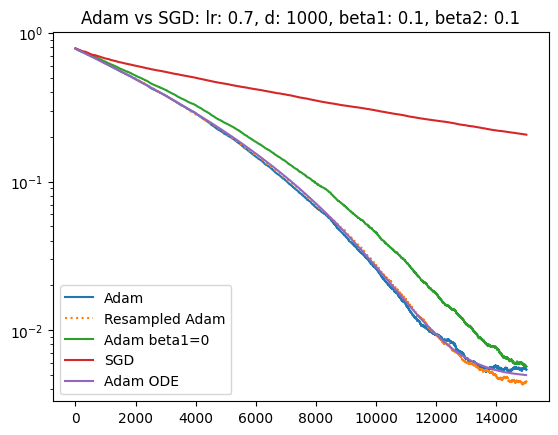

In [ ]:
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE
from optimizers import Adam, SGD, ResampledAdam

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Setup the problem and parameters
problem_type = 'logreg' # from  'logreg' or 'linreg', 'real_phase_ret'

d = 1000 # dimension
m = 1 # number of classes (target dimension)
beta1 = 0.1  # caution setting these values above 0.9 or so without increasing "history_length" 
beta2 = 0.1
T = 15 # time to run SDE for

lr = 0.7 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

# cov = jnp.linspace(0.1, 1, d) # initialize with diagonal covariance
cov = jnp.array([j**(-0.5) for j in range(1, d+1)])
# cov = jnp.ones(d)

key = jax.random.PRNGKey(np.random.randint(0, 10000))
key_init, key_opt, key = jax.random.split(key, 3)

key_init = jax.random.PRNGKey(1331)
key_opt = jax.random.PRNGKey(1331//2)
params0 = jax.random.normal(key_init, (d,m))
# params0 = jnp.ones((d,m)) * 0.5
# optimal_params = params0 + 0.1*jax.random.normal(key_opt, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))

# params0 = jnp.linspace(0.1, 1, d).reshape((d,1))
# optimal_params = jnp.ones((d,m)) * 3



params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)
optimal_params *= 5

# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
# sgd_ode = SgdODE(problem_type)

dt = 0.01
num_samples = 30000
adam_risk, adam_time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = dt, beta1 = beta1, beta2 = beta2, eps = 0.00, num_samples = num_samples)
# sgd_risk, sgd_time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = dt * 2)


# Run the optimizers
adam = Adam(problem_type)
resampled_adam = ResampledAdam(problem_type)
sgd = SGD(problem_type)

_, resampled_adam_risks = resampled_adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)
_, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
opt_p, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = 0.00)
_, adam_risks_beta0 = adam.run(params0, cov, T, lrk, optimal_params, beta1 = 0, beta2 = beta2, eps = 0.00)

# Run the SDE equivalents
sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

# _, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
# params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2)



plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(resampled_adam_risks, label = 'Resampled Adam', ls = ':')
plt.plot(adam_risks_beta0, label = 'Adam beta1=0')
plt.plot(sgd_risks, label = 'SGD')

# plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
# plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

plt.plot(adam_time * d, adam_risk, label = 'Adam ODE')
# plt.plot(sgd_time * d, sgd_risk, label = 'SGD ODE')
plt.title(f'Adam vs SGD: lr: {lr}, d: {d}, beta1: {beta1}, beta2: {beta2}')
plt.legend()
plt.show()

In [12]:
# This compute the mean of the grad update

from risks_and_discounts import f_linreg
from utils import make_B


n_samples = 10000
params = params0 # the learned optimal parameters
B = make_B(params, optimal_params,cov)
f = f_linreg


key, subkey = jax.random.split(key)
key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(subkey, 4)
history_length = 20

Q = jax.random.multivariate_normal(key_Q, mean = jnp.zeros(len(B)), cov = B, shape=(num_samples, 1))
z = jax.random.normal(key_z, (num_samples,1))

Q_history = jax.random.multivariate_normal(key_Q_hist, mean = jnp.zeros(len(B)), cov = B, shape=(num_samples, history_length))
z_history = jax.random.normal(key_z_hist, (num_samples, history_length))

decay_vec1 = jnp.array([beta1**i for i in range(history_length)])* (1-beta1)
decay_vec2 = jnp.array([beta2**i for i in range(history_length)]) * (1-beta2)

fq = f(Q).squeeze(axis=1)
Q = Q.squeeze()

current_grad = fq*z
current_grad2 = current_grad**2

second_moments = []
for l in range(history_length):
    sample_grads = f(Q_history)**2 * z_history[:,:,None]**2
    sample_grads2 = sample_grads.at[:,l,:].set(current_grad)
    second_moment_average = jnp.sqrt(jnp.einsum('abc,b->ac', sample_grads, decay_vec2)) 
    second_moments.append(second_moment_average)
    
second_moments = jnp.array(second_moments)

contributions = current_grad / jnp.array(second_moments)
update = jnp.einsum('abc,a->bc', contributions, decay_vec1) 

op = jnp.einsum('ab,ac->abc', update, update)
op.mean(axis=0)

Array([[15.905837  , -0.09021067],
       [-0.09021067, 15.588154  ]], dtype=float32)

In [11]:
second_moment_average.shape

(10000, 2)

In [10]:
sample_grads.shape

(10000, 20, 2)

In [9]:
# This compute the mean of the grad update

from risks_and_discounts import f_linreg
from utils import make_B


n_samples = 200000
params = params0 # the learned optimal parameters
B = make_B(params, optimal_params,cov)
f = f_linreg


key, subkey = jax.random.split(key)
key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(subkey, 4)
Binv = jnp.linalg.inv(B)

history_length = 250
Q = jax.random.multivariate_normal(key_Q, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, 1))
z = jax.random.normal(key_z, (n_samples,1))

Q_history = jax.random.multivariate_normal(key_Q_hist, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, history_length))
z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

decay_vec2 = jnp.array([beta2**i for i in range(1, history_length + 1)])
decay_vec1 = jnp.array([beta1**i for i in range(1, history_length + 1)])

fq = f(Q).squeeze(axis=1)
Q = Q.squeeze()

second_moment_history = jnp.einsum('abc,b->ac', f(Q_history)**2 * z_history[:,:,None]**2, decay_vec2)
second_moment_average = jnp.sqrt((1-beta2) * (second_moment_history + z**2 * fq**2))

first_moment_history = f(Q_history) * z_history[:,:,None]**2
first_moment_history = first_moment_history / second_moment_average[:,None,:]
first_moment_history = jnp.concatenate([first_moment_history,first_moment_history], axis = -1)
first_moment_history_w_Q = first_moment_history * Q_history @ Binv


current_avg = z**2 * fq / second_moment_average
current_avg = (jnp.concatenate([current_avg,current_avg], axis = -1) * Q @ Binv).mean(axis=0)

history_avg = jnp.einsum('abc,b->ac',first_moment_history_w_Q, decay_vec1).mean(axis=0)

phi = (1-beta1) * (current_avg + history_avg)


print(f'phi: {phi}')
print(f'Condition number of Binv: {jnp.linalg.cond(Binv)}')

KeyboardInterrupt: 

In [ ]:
# This well (eventually) compute the covariance
key_Q, key_Q_hist, key_z, key_z_hist = jax.random.split(key, 4)

history_length = 250
Q = jax.random.multivariate_normal(key_Q, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, 1))
z = jax.random.normal(key_z, (n_samples,1))

Q_history = jax.random.multivariate_normal(key_Q_hist, mean = jnp.zeros(len(B)), cov = B, shape=(n_samples, history_length))
z_history = jax.random.normal(key_z_hist, (n_samples, history_length))

decay_vec1 = jnp.array([beta1**i for i in range(1, history_length + 1)])
decay_vec2 = jnp.array([beta2**i for i in range(1, history_length + 1)])

fq = f(Q).squeeze(axis=1)
Q = Q.squeeze()

second_moment_history = jnp.einsum('abc,b->ac', f(Q_history)**2 * z_history[:,:,None]**2, decay_vec2)
second_moment_average = jnp.sqrt((1-beta2) * (second_moment_history + z**2 * fq**2))

first_moment_history = f(Q_history) * z_history[:,:,None]
first_moment_history = first_moment_history / second_moment_average[:,None,:]

current_avg = z * fq / second_moment_average

history_avg = jnp.einsum('abc,b->ac',first_moment_history, decay_vec1)

vvv = (1-beta1) * (current_avg + history_avg)
op = jnp.einsum('ab,ac->abc', vvv, vvv)
op = op.mean(axis = 0)
# op

In [ ]:
op.shape
# sqrtcov = jnp.linalg.cholesky(cov)

(1, 1)

In [ ]:
from risks_and_discounts import grad_linreg, linreg_target
from utils import make_data

adam_ups = []
n_samps = 1000
hist_length = 50

d_vec1 = jnp.array([beta1**i for i in range(0, hist_length)]) * (1-beta1)
d_vec2 = jnp.array([beta2**i for i in range(0, hist_length)]) * (1-beta2)

for _ in range(n_samps):
    grad_hist = []
    for _ in range(hist_length):
        dat = make_data(cov)
        target = linreg_target(optimal_params,dat)
        grad = grad_linreg(params,dat,target)
        grad_hist.append(grad)
    grad_hist = jnp.array(grad_hist)
    
    m = jnp.einsum('a,abc->bc', d_vec1, grad_hist)
    v = jnp.einsum('a,abc->bc', d_vec2, grad_hist**2)
    
    adam_up = m / jnp.sqrt(v)
    adam_ups.append(adam_up)
adam_ups = jnp.array(adam_ups)
    
adam_mean = np.mean(adam_ups,axis=0)

adam_cov = jnp.einsum('abc,adc->abdc', adam_ups, adam_ups)
adam_cov = jnp.mean(adam_cov,axis=0).squeeze()

# check the mean adam update vs theory. this relies on params0 - optimal_params being a constant vector or near enough. Also uses identity covariance
print(f'empirical_mean {adam_mean.mean(axis=0)}')
print(f'computed mean: {(params0 - optimal_params).mean() * phi[0]}')

print('-' * 20)

m_of, std_of = stats_off_diag(adam_cov)
print(f'avg diagonal of adam cov: {jnp.diag(adam_cov).mean():0.5}')
print(f'avg off diagonal: {m_of}')
print(f'std off diagonal: {std_of}')
print(f'std diagonal: {jnp.diag(adam_cov).std():0.5}')

print(f'Theory cov = {op.mean():0.5} Id')

In [ ]:
grad.shape

(1000, 1)